In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")
tf.keras.backend.clear_session()

print('Num GPU Available:', len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_built_with_cuda()
print(tf.config.experimental.list_physical_devices('GPU'))

Num GPU Available: 1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
pip install split-folders

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
%cd "/content/gdrive/MyDrive/SKRIPSI/CODE_V3"

/content/gdrive/MyDrive/SKRIPSI/CODE_V3


## Manual

In [ ]:
import zipfile

local_zip = 'dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall()
zip_ref.close()

KeyboardInterrupt: 

In [ ]:
import splitfolders

# Path ke folder dataset setelah diekstrak dari dataset.zip
input_folder = "dataset/"

# Path output untuk menyimpan dataset yang sudah dibagi
output_folder = "dataset_split"



In [ ]:
# Membagi dataset dengan rasio 70% train, 15% val, 15% test
splitfolders.ratio(
    input_folder,
    output=output_folder,
    seed=42,
    ratio=(0.7, 0.15, 0.15),
    group_prefix=None,
    move=True  # Pindahkan file (bukan copy)
)

print("\nDataset berhasil dipisahkan ke train, val, dan test!")

In [ ]:
%ls dataset_split/

In [ ]:
%ls dataset_split/val/

In [ ]:
# create train, val, test paths
import os
base_dir = 'dataset_split/'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'test')
test_dir = os.path.join(base_dir, 'val')

ds_path = os.path.join(validation_dir, 'downSyndrome')
h_path = os.path.join(validation_dir, 'healty')

In [ ]:
import os

# Periksa apakah direktori validasi dan subfolder ada
print("Validation Directory Exists:", os.path.exists(validation_dir))
print("Down_syndrome Path Exists:", os.path.exists(ds_path))
print("Healty Path Exists:", os.path.exists(h_path))

# List isi folder downSyndrome jika ada
if os.path.exists(ds_path):
    print("Files in downSyndrome:", os.listdir(ds_path)[:5])

In [ ]:
import os
import random
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

fig, ax = plt.subplots(2, 4, figsize=(9, 5))
# Ambil list file dari direktori secara dinamis
downSyndrome = os.listdir(ds_path) if os.path.exists(ds_path) else []
healty = os.listdir(h_path) if os.path.exists(h_path) else []

for i in range(2):
    for j in range(4):
        if i == 0:
            sample_downSyndrome = downSyndrome[j]
            image = load_img(validation_dir + "/downSyndrome/" + sample_downSyndrome)
            ax[i, j].imshow(image)
            ax[i, j].set_title("Autism")
        else:
            sample_healty = healty[j]
            image = load_img(validation_dir + "/healty/" + sample_healty)
            ax[i, j].imshow(image)
            ax[i, j].set_title("Non-Autism")
        ax[i, j].axis("off")

plt.show()

In [ ]:
print(f'{downSyndrome[:5]} \n{healty[:5]}')

['down_10.jpg', 'down_1003.jpg', 'down_101.jpg', 'down_1010.jpg', 'down_1019.jpg'] 
['healty_10.jpg', 'healty_1003.jpg', 'healty_101.jpg', 'healty_1010.jpg', 'healty_1019.jpg']


In [ ]:
target_size = (150, 150)

In [ ]:
import cv2

def gathering(path):
    images = []
    labels = []
    for r, d, f in os.walk(path):
        for file in f:
            if ".jpeg" or ".jpg" in file:
                imagePath = os.path.join(r, file)
                image = cv2.imread(imagePath)
                image = cv2.resize(image, target_size)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                images.append(image)
                label = imagePath.split(os.path.sep)[-2]
                labels.append(label)


    return np.array(images), np.array(labels)

In [ ]:
x_train, y_train = gathering(train_dir)
x_test, y_test = gathering(test_dir)
x_val, y_val = gathering(validation_dir)

In [ ]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [ ]:
print('Train shape:', x_train.shape)
print('Test shape:', x_test.shape)
print('Validation shape:', x_val.shape)

Train shape: (2099, 150, 150, 3)
Test shape: (449, 150, 150, 3)
Validation shape: (451, 150, 150, 3)


In [ ]:
y_train

array(['downSyndrome', 'downSyndrome', 'downSyndrome', ..., 'healty',
       'healty', 'healty'], dtype='<U12')

In [ ]:
lb = LabelEncoder()
y_train = lb.fit_transform(y_train)
y_val = lb.fit_transform(y_val)
y_test = lb.fit_transform(y_test)

In [ ]:
y_train

array([0, 0, 0, ..., 1, 1, 1])

In [ ]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation untuk training set
train_datagen = ImageDataGenerator(
    rescale=1./255,               # Normalisasi nilai piksel ke [0,1]
    rotation_range=30,            # Rotasi gambar hingga 20 derajat
    zoom_range=0.1,               # Zoom in/out hingga 20%
    width_shift_range=0.1,        # Pergeseran horizontal hingga 20% dari lebar gambar
    height_shift_range=0.1,       # Pergeseran vertikal hingga 20% dari tinggi gambar
    horizontal_flip=True,         # Membalik gambar secara horizontal
    brightness_range=(0.8, 1.2),  # Variasi kecerahan antara 80% hingga 120%
    fill_mode="nearest"           # Mengisi area kosong setelah transformasi
)

# Data augmentation untuk validasi dan testing (hanya normalisasi)
val_test_datagen = ImageDataGenerator(rescale=1./255)

# Load dataset dari folder menggunakan ImageDataGenerator
train_generator = train_datagen.flow_from_directory(
    "dataset_split/train",
    target_size=target_size,   # Ukuran input sesuai EfficientNetB3
    batch_size=32,
    class_mode="categorical"
)

val_generator = val_test_datagen.flow_from_directory(
    "dataset_split/val",
    target_size=target_size,
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

test_generator = val_test_datagen.flow_from_directory(
    "dataset_split/test",
    target_size=target_size,
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

Found 2099 images belonging to 2 classes.
Found 449 images belonging to 2 classes.
Found 451 images belonging to 2 classes.


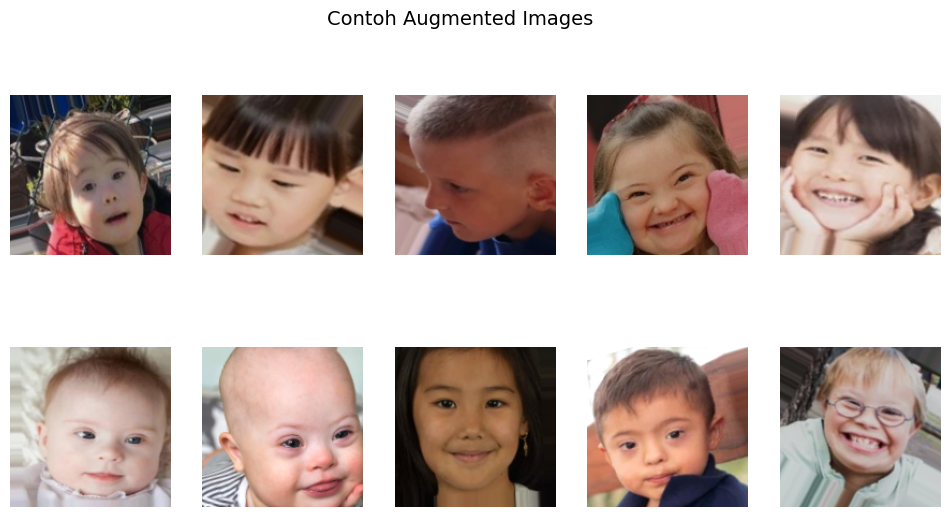

In [ ]:
# Contoh menampilkan gambar setelah augmentasi
import matplotlib.pyplot as plt

# Ambil satu batch gambar dari generator
x_batch, y_batch = next(train_generator)

fig, axes = plt.subplots(2, 5, figsize=(12, 6))
fig.suptitle("Contoh Augmented Images", fontsize=14)

for i, ax in enumerate(axes.flat):
    ax.imshow(x_batch[i])
    ax.axis("off")

plt.show()

In [ ]:

modelEfficientNetB3 = tf.keras.applications.efficientnet.EfficientNetB3(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(target_size[0], target_size[1], 3),
    pooling='max',
    # classifier_activation='softmax'
)

43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

# Assuming 'modelEfficientNetB3' is your pre-trained model
x = modelEfficientNetB3.output

x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(rate=0.5)(x)

x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(rate=0.5)(x)

# Output layer
output = Dense(1, activation='sigmoid')(x)

# Create the modified model
model = Model(inputs=modelEfficientNetB3.input, outputs=output, name='BinarySkinCancerClassification_EfficientNetB3')

# Compile the model
model.compile(Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "BinarySkinCancerClassification_EfficientNetB3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 150, 150,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 150, 150,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 150, 150,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 151, 151,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 75, 75,    │      1,080 │ stem_conv_pad[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 75, 75,    │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 75, 75,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 75, 75,    │        360 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 75, 75,    │        160 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 75, 75,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 40)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 40)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 10)  │        410 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 40)  │        440 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 75, 75,    │          0 │ block1a_activati… │
│ (Multiply)          │ 40)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 75, 75,    │        960 │ block1a_se_excit

 Total params: 11,211,568 (42.77 MB)

 Trainable params: 11,123,497 (42.43 MB)

 Non-trainable params: 88,071 (344.03 KB)

In [ ]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, Sequential


model = Sequential(name = 'DownSyndromeClassification_EfficientNetB3')
model.add(modelEfficientNetB3)

model.add(Dense(256, activation='relu'))
# model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(2, activation='softmax'))
model.compile(Adam(learning_rate=0.0001), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

# model.add(Dense(1, activation='sigmoid'))
# model.compile(Adam(learning_rate=0.001), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "DownSyndromeClassification_EfficientNetB3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 1536)           │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       393,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,210,673 (42.77 MB)

 Trainable params: 11,123,114 (42.43 MB)

 Non-trainable params: 87,559 (342.03 KB)

In [ ]:
from tensorflow.keras.callbacks import Callback

class MyReduceLROnPlateau(Callback):
    def __init__(self, monitor_metrics=('val_loss', 'val_accuracy'), factor=0.5, patience=5):
        super(MyReduceLROnPlateau, self).__init__()
        self.monitor_metrics = monitor_metrics
        self.factor = factor
        self.patience = patience
        # self.min_lr = 1e-8

    def on_epoch_end(self, epoch, logs=None):
        current_values = [logs[metric] for metric in self.monitor_metrics]
        if all(value is not None for value in current_values):
            if epoch > 0 and (epoch + 1) % self.patience == 0:
                # Check if all monitored metrics have stopped improving
                if all(current_values[i] >= logs[self.monitor_metrics[i]] for i in range(len(self.monitor_metrics))):
                    old_lr = float(tf.keras.backend.get_value(self.model.optimizer.lr))
                    # new_lr = max(old_lr * self.factor
                    #             , self.min_lr
                    #              )
                    new_lr = old_lr * self.factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, new_lr)
                    print(f'Reducing learning rate to {new_lr}.')

lr_reduction = MyReduceLROnPlateau(monitor_metrics=('val_loss', 'val_accuracy'))
callbacks = [lr_reduction]


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # or 'val_accuracy'
    patience=10,           # Number of epochs with no improvement after which training will be stopped
    min_delta=0.001,       # Minimum change in the monitored quantity to qualify as an improvement
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

lr_reduction = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', patience=3, factor=0.5,
    min_lr=1e-08,
    # min_lr=1e-8,
    verbose=1
)

checkpoint = tf.keras.callbacks.ModelCheckpoint("./model_EfB3.h5",
                                                monitor="val_acc",
                                                verbose=1,
                                                save_best_only=True,
                                                mode="max")

callbacks = [
            lr_reduction,
            #  early_stopping,
            #  checkpoint
             ]

## Datagen

In [ ]:
history = model.fit(
                    train_generator,
                    validation_data=val_generator,
                    # x = x_train, y = y_train, batch_size = 32,
                    # validation_data=(x_val, y_val),
                    epochs = 50,
                    callbacks = [callbacks]
                    )

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 230s 2s/step - accuracy: 0.5182 - loss: 1.0638 - val_accuracy: 0.4989 - val_loss: 0.9015 - learning_rate: 1.0000e-04
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 25s 378ms/step - accuracy: 0.6024 - loss: 0.8785 - val_accuracy: 0.4989 - val_loss: 1.6539 - learning_rate: 1.0000e-04
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 41s 377ms/step - accuracy: 0.6684 - loss: 0.7244 - val_accuracy: 0.4989 - val_loss: 2.1928 - learning_rate: 1.0000e-04
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step - accuracy: 0.7133 - loss: 0.6513
Epoch 4: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
66/66 ━━━━━━━━━━━━━━━━━━━━ 25s 377ms/step - accuracy: 0.7134 - loss: 0.6509 - val_accuracy: 0.4989 - val_loss: 1.1647 - learning_rate: 1.0000e-04
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 41s 377ms/step - accuracy: 0.7866 - loss: 0.4964 - val_accuracy: 0.5301 - val_loss: 0.9248 - learning_rate: 5.0000e-05
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 25s 376ms/step - accuracy: 0

In [ ]:
# from tensorflow.keras.models import load_model

# # Load the model
# model = load_model('model_86-25.h5')
# test_dir = 'Dataset/skin300/val'
# x_test, y_test = gathering(test_dir)
# x_test = np.array(x_test) / 255
# y_test = lb.fit_transform(y_test)

In [ ]:
# evaluate = model.evaluate(x_test, y_test)
evaluate = model.evaluate(test_generator)
print("Loss of the model is - " , evaluate[0])
print("Accuracy of the model is - " , evaluate[1]*100 , "%")
# display(evaluate)

15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 597ms/step - accuracy: 0.9251 - loss: 0.2339
Loss of the model is -  0.22473520040512085
Accuracy of the model is -  92.01774001121521 %


Text(0.5, 1.0, 'Accuracy Evolution with 92%')

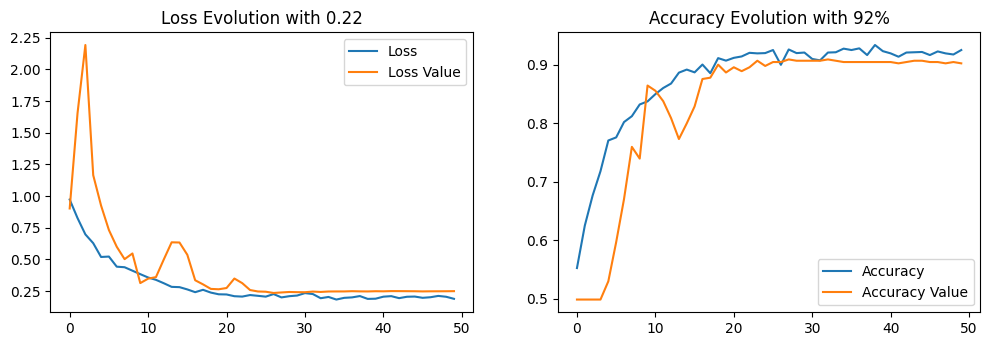

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history.history['loss'], label='Loss')
plt.plot(history.history['val_loss'], label='Loss Value')
plt.legend()
plt.title("Loss Evolution with {:.2f}".format(evaluate[0]))

plt.subplot(2, 2, 2)
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label='Accuracy Value')
plt.legend()
plt.title("Accuracy Evolution with {}%".format(round(evaluate[1]*100)))


In [ ]:
# Melakukan prediksi menggunakan generator
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)  # Mengambil kelas dengan probabilitas tertinggi

# Mendapatkan label asli dari test_generator
y_true = test_generator.classes  # Label asli dari test_generator
class_labels = list(test_generator.class_indices.keys())  # Nama kelas

15/15 ━━━━━━━━━━━━━━━━━━━━ 19s 758ms/step


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_labels))

Classification Report:

              precision    recall  f1-score   support

downSyndrome       0.91      0.93      0.92       225
      healty       0.93      0.91      0.92       226

    accuracy                           0.92       451
   macro avg       0.92      0.92      0.92       451
weighted avg       0.92      0.92      0.92       451



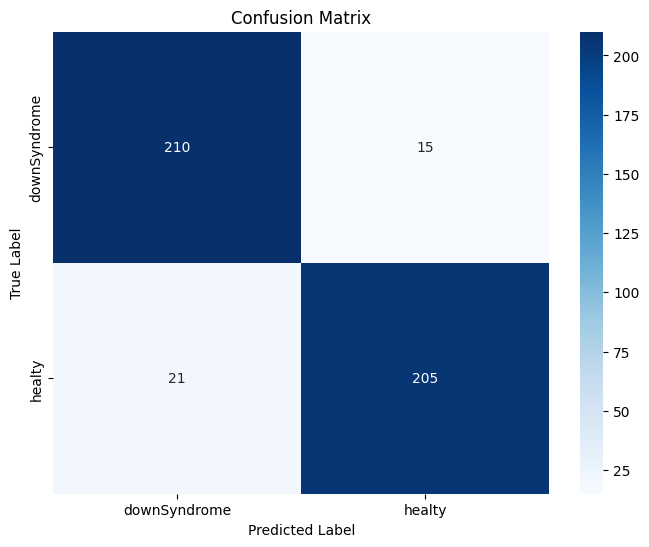

In [ ]:
# Buat confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Visualisasi menggunakan heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Save the history object using pickle
with open('history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

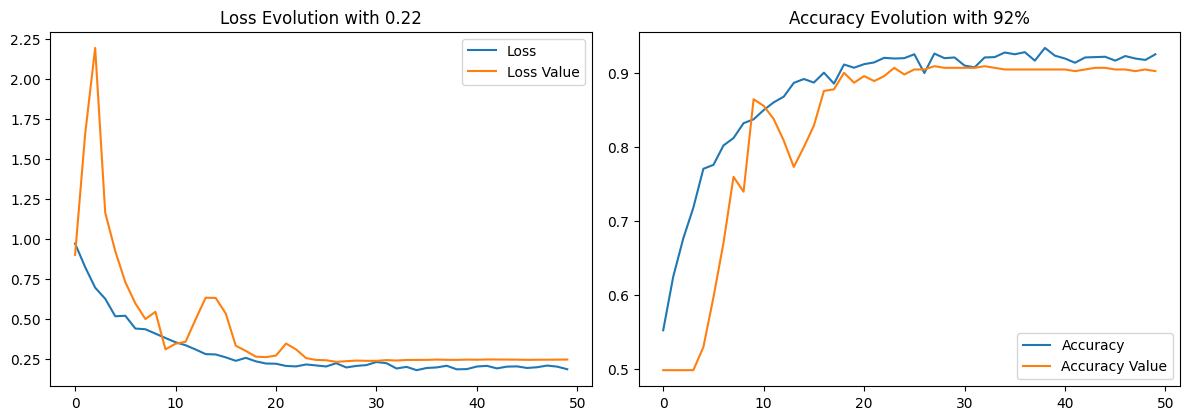

In [ ]:
#  Load the history object using pickle
with open('history.pkl', 'rb') as file:
    history = pickle.load(file)

plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(history['loss'], label='Loss')
plt.plot(history['val_loss'], label='Loss Value')
plt.legend()
plt.title("Loss Evolution with {:.2f}".format(evaluate[0]))

plt.subplot(2, 2, 2)
plt.plot(history['accuracy'], label='Accuracy')
plt.plot(history['val_accuracy'], label='Accuracy Value')
plt.legend()
plt.title("Accuracy Evolution with {}%".format(round(evaluate[1]*100)))

plt.tight_layout()
plt.show()